In [1]:
using LinearAlgebra
using Plots
using KrylovKit
using Trapz
using DelimitedFiles


### Defining $V$ 

For L sites and 2 impurities, $V$ is a $2\times L$ matrix, containing the hopping between conduction band and impurities only. 

In [76]:
function V(L, ialpha::Int64, ibeta::Int64, V1, V2)
    V_ = zeros((2,Int(L))) .+ 0im
    V_[1, ialpha] = V1
    V_[2, ibeta] = V2
    
    return V_   
end


V (generic function with 1 method)

### Defining $\hat{G}_{0}$

In [3]:
function H0(L)
    T = zeros(L, L) 
    T[diagind(T)] .=-1
    T = circshift(T, (0,1)) + circshift(T, (1,0))
    T[1, L] = 0
    T[L, 1] = 0
    
    return T
end

H0 (generic function with 1 method)

In [73]:
function H_trian()
    return reverse(readdlm("Cb_Hamiltonian_2_87", ' ', Float64));
end


H_trian (generic function with 1 method)

In [75]:
function Greens_ij(alpha, E_, w, mu, i, j)
    G1 = 0im
    for (k,E) in enumerate(E_)
        G1 += alpha[i, k]*alpha[j, k] /(w - E + mu)
    end
    return G1
end

Greens_ij (generic function with 1 method)

In [77]:
function G0(w, mu, E, alpha)
    L = length(E)
    G0_ = zeros((L,L)).+0im

    
    for i in collect(1:L)
        for j in collect(1:L)
            G0_[i,j] = Greens_ij(alpha, E, w, mu, i, j)
        end
    end
    return G0_ 
end

G0 (generic function with 1 method)

### Defining $\zeta_{i}$ 

We must implement the equation $\zeta_{\alpha, \sigma} = i\omega_{n} + \mu - \epsilon_{\sigma} - \Sigma_{\alpha \alpha, \sigma (i\omega_{n})}$

But I will already ignore the chemical potential. We can take $\mu = 0$ with no loss of generality. Here, $\epsilon_{\sigma}$ is the on-site energy of both impurities. 

In [78]:
function zeta(w, ed, S, index)
    return w - ed - S[index, index]
end

zeta (generic function with 1 method)

### Defining $\Delta_{ij}$

Now, we must implement the equation $\Delta_{\alpha, \beta} (i \omega_{n}) = V G^{0}_{i_{\alpha}i_{\beta}}(i \omega_{n}) V$


In [79]:
function Delta(w, V1, ialpha::Int64, ibeta::Int64, mu, E, alpha)
    
    Delta_ = zeros((2,2)) .+ 0im
    
    Delta_[1,1] = V1^2*Greens_ij(alpha, E, w, mu, ialpha, ialpha)
    Delta_[2,2] = V1^2*Greens_ij(alpha, E, w, mu, ibeta, ibeta)
    
    Delta_[2,1] = V1^2*Greens_ij(alpha, E, w, mu, ibeta, ialpha)
    Delta_[1,2] = V1^2*Greens_ij(alpha, E, w, mu, ialpha, ibeta)
    
    return Delta_
end

Delta (generic function with 1 method)

### Defining $G^{imp}$
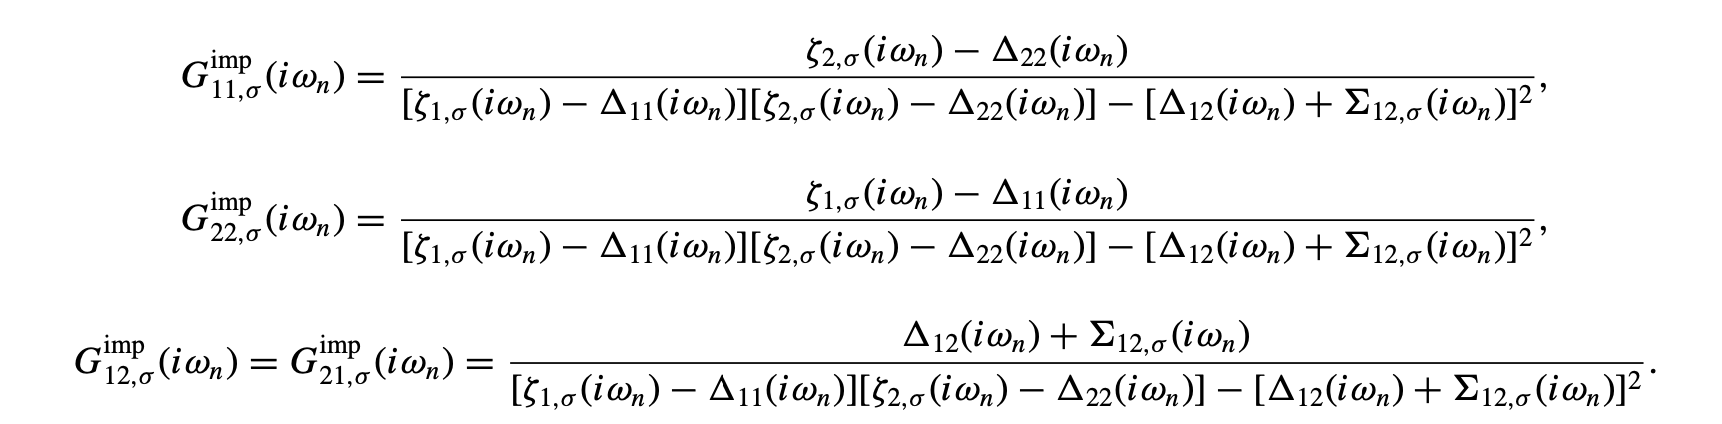

In [80]:
function G_imp(w, S1, S2, mu, E, alpha, params)
    ialpha, ibeta, V1, ed, h = params 
    D = Delta(w, V1, Int(ialpha), Int(ibeta), mu, E, alpha)
    zeta1 = w + mu - ed - S1
    zeta2 =  w + mu - ed - S2 + h

    G11 = (zeta2 - D[2,2])/((zeta1 - D[1,1])*(zeta2 - D[2,2])-(D[1,2])^2)
    G22 = (zeta1 - D[1,1])/((zeta1 - D[1,1])*(zeta2 - D[2,2])-(D[1,2])^2)
    G12 = (D[1,2])/((zeta1 - D[1,1])*(zeta2 - D[2,2])-(D[1,2])^2)
    
    G_imp_ = [G11 G12; G12 G22]
    
    return G_imp_
end

function G_imp_loop(w_, S_, mu, E, alpha, params)
    G_1 = []
    G_2 = []
    ialpha, ibeta, V1, ed, h = params 

    for (i, w) in enumerate(w_)
    
        D = Delta(w, V1, Int(ialpha), Int(ibeta), mu, E, alpha)
        zeta1 = w + mu - ed - S_[1, i] #zeta(w, ed, S, 1)
        zeta2 = w + mu - ed - S_[2, i] + h #zeta(w, ed, S, 2)

        G11 = (zeta2 - D[2,2])/((zeta1 - D[1,1])*(zeta2 - D[2,2])-(D[1,2])^2)
        G22 = (zeta1 - D[1,1])/((zeta1 - D[1,1])*(zeta2 - D[2,2])-(D[1,2])^2)
    
        push!(G_1, G11)
        push!(G_2, G22)
    end

    return G_1, G_2
end



G_imp_loop (generic function with 1 method)

### Defining $G^{sub}$
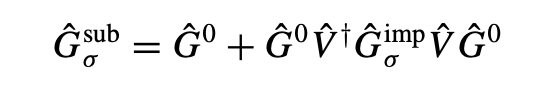

In [81]:
function G_sub(w, mu, E, alpha, params, S1, S2)
    ialpha, ibeta, V1, ed, h = params 
    L = length(E)
    G0_ = G0(w, mu, E, alpha)
    V_ = V(L, Int(ialpha), Int(ibeta), V1, V1)
    G_imp_ = G_imp(w, S1, S2, mu, E, alpha, params)
    
    A = G0_*adjoint(V_)
    B = V_*G0_
    C = G_imp_*B
    D = A*C
    
    return D + G0_
end

G_sub (generic function with 1 method)

### Defining $\hat{G}_{\sigma}(\omega)$

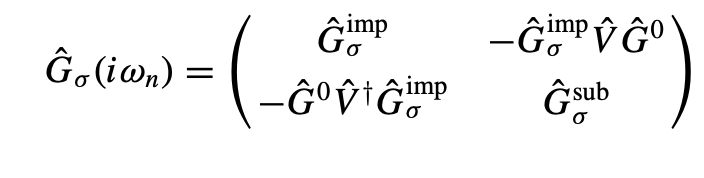


In [82]:
function G(w, mu, E, alpha, params, S1, S2)
    L = length(E)
    ialpha, ibeta, V1, ed, h = params 

    G_imp_ = G_imp(w, S1, S2, mu, E, alpha, params)
    G0_ = G0(w, mu, E, alpha)
    V_ = V(L, Int(ialpha), Int(ibeta), V1, V1)
    V_d = adjoint(V_)
    G_sub_ = G_sub(w, mu, E, alpha, params, S1, S2)
    
    G_ = zeros(Int(L+2), Int(L+2)) .+ 0im

    G_[1:2, 1:2] .= G_imp_
    G_[3:end, 3:end] .= G_sub_
    G_[1:2, 3:end] .= -(G_imp_*(V_*G0_))
    G_[3:end, 1:2] .= -(G0_*(V_d*G_imp_))
    
    return G_
end

G (generic function with 1 method)

In [83]:
include("impuritysolver.jl")
include("DMFT_sublime.jl")


Anderson_parameters_g (generic function with 1 method)

In [84]:
function lanczos_green2(w, En, U, V, N)
    #the first step is finding the ground state
    val_min = []
    vec_min = []
    
    charge_spin = []
    
    final_GF = zeros(length(w)).*1im

    push!(charge_spin, [0, 0])
    push!(val_min, 0.)
    push!(vec_min, [[0.]])
    for m = 1:2*N
        H_, Sz_ = Hamiltonian(m, N, En, U, V)
        for (i, H) in enumerate(H_)
            val, vec, conv = eigsolve(H, size(H)[1], 1,:SR)
            
            push!(charge_spin, [m, Sz_[i]])
            push!(val_min, val[1])
            push!(vec_min, vec[:,1][1])
        end
    end
    
    m_GS_min = argmin(val_min) 
    
    m_GS_ = findall2(<=(0.000001), abs.(val_min.-val_min[m_GS_min]))
    GS_ = vec_min[m_GS_]
    eGS_ = val_min[m_GS_]
    N_deg = length(m_GS_)
    print(eGS_)
    
    for (ii,m_GS) in enumerate(m_GS_)

        GS = GS_[ii]
        eGS = eGS_[ii]
                            
        QGS = Int(charge_spin[m_GS][1])
        SzGS = Int(charge_spin[m_GS][2])
        st = states_N_Q_Sz(N, QGS, SzGS) 
        
############################################################################################      
        A = []
        B = []
        n = 0
        #acting the anihilation operator dup
        if SzGS != -QGS #only then this has a chance of not being zero!
            coef = []

            st_1 = states_N_Q_Sz(N, QGS - 1, SzGS - 1) 
            for (i, v) in enumerate(GS)
                dup = st[2][i][1]
                if dup == 1
                   push!(coef, [v , st[1][i] - 2^(2*N-1)])
                end
            end
        
            #computing the lanczos seed
            lanczos0 = zeros(length(st_1[1]))
            for (i, c) in enumerate(coef)
               lanczos0[findall(==(c[2]), st_1[1])] .= c[1]
            end

            n = norm(lanczos0)

            seed = lanczos0/norm(lanczos0)
        
        
            s_minus = SzGS-1
            if QGS - 1 == 0
                s_minus = 0
            end
            H, Sz = Hamiltonian(QGS - 1, N, En, U, V)
            R, A, B = lanczos(H[findall2(==(s_minus), Sz)[1]], seed, length(seed)-1);
        end
############################################################################################
        #acting the creation operator dup
        coef = []
        st_1 =  states_N_Q_Sz(N, QGS + 1, SzGS + 1) 
        for (i, v) in enumerate(GS)
            dup = st[2][i][1]
            if dup == 0
                push!(coef, [v , st[1][i] + 2^(2*N-1)])
            end
        end
        
        #computing the lanczos seed
        lanczos0_ = zeros(length(st_1[1]))
        for (i, c) in enumerate(coef)
           lanczos0_[findall(==(c[2]), st_1[1])] .= c[1]
        end
    
        n_ = norm(lanczos0_)
        
        

        seed_ = lanczos0_/norm(lanczos0_)
        
        H_, Sz_ = Hamiltonian(QGS + 1, N, En, U, V)
        R_, A_, B_ = lanczos(H_[findall2(==(SzGS+1), Sz_)[1]], seed_, length(seed_)-1);
        G_ = []
        for (i,z) in enumerate(w)
            final_GF[i]+= -G_b(-z+eGS, A_, B_, n_^2) - G_b(-z-eGS, -A, B, n^2) 
        end

    end
    
    
    return -final_GF./N_deg
end    

lanczos_green2 (generic function with 1 method)

In [85]:
function DMFT(U, params) 
    n_iterations = 20
    N = 7 #number of sites in the effective impurity models 
  
    nmax = 5000
    beta = 1000
    iwn_ = (2 .*collect(1:nmax) .+1).*pi*1im/beta 

    S_ = zeros(2, length(iwn_)) .+ 0im

    p1,p2 = [zeros(2*(N-1)), zeros(2*(N-1))]

    V1, En1, V2, En2 = [zeros(N-1),zeros(N-1),zeros(N-1),zeros(N-1)]

    p0_1 = rand(2*(N-1))
    p0_2 = rand(2*(N-1))

    E_, alpha = eigen(H_trian())
    L = length(E_)
    print("energia ok")

    a = 1.0;
    mu = 0.;
    
    #_______________________________________________________________________LOOP_____________________________#
    #__________________________________________________________________________________________________________#
    #______________________________ LOOP______________________________________________________________________#
    #________________________________________________________LOOP____________________________________________#
    #_________LOOP___________________________________________________________________________________________#
    
    for i = 1:n_iterations
    G_imp1, G_imp2 = G_imp_loop(iwn_, S_, mu, E_, alpha, params)
    
    V1, En1, p1 = Anderson_parameters_g((1 ./G_imp1 + S_[1,:]),iwn_, -U/2,0., N,p0_1)
    V2, En2, p2 = Anderson_parameters_g((1 ./G_imp2 + S_[2,:]),iwn_, -U/2, params[5], N, p0_2)
    print("\t fit ok \n")
    
    En2[1] = -U/2 - params[5]
    En2[2] = -U/2 + params[5]
    
    print("\t fit ok \n")

    
    print(p1, "\t", p2, "\n")
    
    S1_old = copy(S_[1, 1:end])
    S2_old = copy(S_[2, 1:end])
    
    S_[1, 1:end] = a.*(G0_anderson_1(iwn_, -U/2, 0., p1) - 1 ./lanczos_green2(-iwn_, En1, U, V1, N)) + (1-a).*S_[1, 1:end]  
    S_[2, 1:end] = a.*(G0_anderson_1(iwn_, -U/2, params[5], p2) - 1 ./lanczos_green2(-iwn_, En2, U, V2, N)) + (1-a).*S_[2, 1:end]  
    print("\t S \n")
    
    d1 = mean(abs.(S1_old - S_[1, 1:end]))
    d2 = mean(abs.(S2_old - S_[2, 1:end]))
    
    print("\n \t", d1, "\t", d2, "\n")
   
    if d1 < 10e-5 && d2 < 10e-5
        break
    end
    
   
    p0_1 = rand(2*(N-1))
    p0_2 = rand(2*(N-1))

    
    end
    
    x = collect(-10:0.001:10) .+ 0.009im;
    S_x = zeros(2,length(x)) .+ 0im;


    S_x[1, 1:end] = G0_anderson_1(x, -U/2, 0., p1) - 1 ./lanczos_green2(-x, En1, U, V1, N);
    S_x[2, 1:end] = G0_anderson_1(x, -U/2, params[5], p2) - 1 ./lanczos_green2(-x, En2, U, V2, N);

    G_imp1, G_imp2 = G_imp_loop(x, S_x, 0., E_, alpha, params);

    Spectrals = zeros(L+2, length(x))
    for (i, x_) in enumerate(x)
        aux = diag(-imag(G(x[i], 0, E_, alpha, params, S_x[1, i], S_x[2, i])))
        for (j, a_) in enumerate(aux)
            Spectrals[j, i] = a_
        end
    end

    nup_ = []
    for i in collect(1:L+2)
        push!(nup_, trapz(real(x)[1:10001],Spectrals[i, 1:10001])/trapz(real(x), Spectrals[i, 1:end]))
    end

    return nup_
end

DMFT (generic function with 1 method)

In [ ]:
U = 1.
ialpha = Int(1)
ibeta = Int(64)

n_02a= []
n_05a= []
n_00a= []
x = collect(0.5:0.2: 4)

for U in 2.87^2 ./x
    params = [ialpha, ibeta, 2.87, -U/2, -0.05]
    push!(n_05a, DMFT(U, params))
    params = [ialpha, ibeta, 2.87, -U/2, 0.]
    push!(n_00a, DMFT(U, params))
end

energia ok
 
 distance:0.007609826109668809
 

 
 distance:0.0076244152538804824
 
	 fit ok 
	 fit ok 
[1.0306098476990426, 0.6650743255039409, 1.7867458649455592, 1.0298685079795933, 1.2039168144543908, 1.0098732024679677, 2.691171135019105, 0.4881260111813896, -1.3320055632018757, -0.31293747672660405, 1.0464405004415123, 0.05418384307808943]	[1.0093439083393556, 1.2029418957644742, 1.031004926339464, 1.0279773322656125, 1.7880192251663336, 0.6664775925890756, 0.05396426438267183, 1.0463758198310866, 2.6900609352520024, -0.31126832881257815, -1.3307284161705097, 0.4892420700502769]
Any[-13.436065471507483]Any[-13.431458279193562]	 S 

 	8.787110592124797	9.12784741347787

 
 distance:0.0019274106209825924
 

 
 distance:0.0019431689209806458
 
	 fit ok 
	 fit ok 
[1.3838460019072207, 0.9423263686116775, 0.8973271008075231, 1.2346904390409537, 1.2748356481592964, 1.2134889396814945, -1.6585482296078664, 0.09950055313930077, -0.3280683170843185, 2.3191865475437927, -0.7877877466305714,

 distance:0.0019374020433688753
 

 
 distance:0.002097293256166458
 
	 fit ok 
	 fit ok 
[1.2333107953267801, 1.3964317992209447, 1.2130567743529432, 1.2761407403007603, 0.8722585232570264, 0.9478832524233426, 2.321729494597884, -1.6506665384560897, 0.6887235682900221, -0.77013227297862, -0.3239436559307839, 0.09893345549452885]	[1.2281270490174845, 1.252571405808964, 0.9768089556390688, 1.6634433211797977, 0.8915217235745418, 0.7989472392568002, 1.1282224940518975, -0.430575253809336, 2.8130580305274218, -1.44585862572383, 0.0918015412500372, 0.3806731315761172]
Any[-15.559070366060835]Any[-13.823008107519193]	 S 

 	2.523356565303892e-5	0.006203519012498458

 
 distance:0.0020976051999252177
 

 
 distance:0.001937785849470802
 
	 fit ok 
	 fit ok 
[0.9768147657398313, 1.6634295255218192, 1.2525748820673142, 1.2281388442192578, -0.7989086654928033, 0.89155473818282, 2.8130509450411743, -1.4458706388210913, -0.4305947859596104, 1.1282025944109728, 0.38065835466204145, 0.0917977762044

Any[-11.854151582626647]Any[-11.08187482967051]	 S 

 	4.639461287008944	4.742369824816426

 
 distance:0.0020142391591316685
 

 
 distance:0.0019707552470749515
 
	 fit ok 
	 fit ok 
[0.8851513085918283, 1.2590664935233655, 1.658857386279964, -1.2240269754678748, 0.8210974840755432, 0.9688709510766552, 0.0924887085578958, -0.4349220308133151, -1.4498555603127599, 1.1457570176042637, 0.3863673494107928, 2.827946398787124]	[1.4075745610960162, 0.8555556127799563, 1.2390098943747998, -1.2734194980302693, 1.2103875392140695, 0.9461631493965235, -1.643323493605848, -0.32537303681854346, 2.310969942898838, -0.7556156397703833, 0.6794403923586785, 0.09913789412776496]
Any[-11.045492493536274]Any[-12.726496548164032]	 S 

 	0.006653562186216862	0.008542281730888699

 
 distance:0.002013787227142558
 

 
 distance:0.002024952980237112
 
	 fit ok 
	 fit ok 
[0.9687521537932658, 0.884649652559015, 1.2238110510041402, 1.2589183265626414, 1.6591619523929235, 0.8217069649757489, 2.8280920630021384

Any[-10.571941813482075]Any[-11.238313981959879]	 S 

 	3.764354062304061	3.7645561912851977

 
 distance:0.001973318863051859
 

 
 distance:0.0020154025072405906
 
	 fit ok 
	 fit ok 
[1.2101016276803123, 0.9452981701068449, 0.8564681843790988, 1.2727525270619309, 1.239932638486826, 1.4076277194469775, 0.6778505464551027, 0.09921479274958729, -0.32615559324989657, -0.7557489435112128, 2.3092341790163653, -1.6432498436157226]	[0.8884922750136817, 0.8186160298877978, 0.9689592879116393, 1.2252538540679907, 1.6561074461620653, 1.26071568073084, 0.09212625170149256, 0.38445152478498884, 2.828354004712056, 1.1446063603123997, -1.4522410322229735, -0.43839511603427694]
Any[-12.156363532769282]Any[-10.487749960705347]	 S 

 	0.004707893807587769	0.004184840799993651

 
 distance:0.0019725799189012723
 

 
 distance:0.0020147213148936655
 
	 fit ok 
	 fit ok 
[0.9450322645637164, 1.406899945810057, 1.2399825299183662, 1.2725475064475547, 1.2101344382632184, 0.8581420654645712, 0.099239258682

Any[-10.10940974357298]Any[-11.781298107853555]	 S 

 	0.0003068173875333385	5.852527175709492e-7

 
 distance:0.0019740315839609
 

 
 distance:0.001974072207968759
 
	 fit ok 
	 fit ok 
[0.8584128090982842, -1.2404960475085047, 1.2721915195317863, 1.4070427764599722, 1.20997415205241, 0.9445761052981673, -0.32686532752762737, 2.3081763062126273, -0.7567414866040045, -1.643597427811161, 0.6768534638499596, 0.09927783286713263]	[1.2099722912738642, -0.8583086019296444, 1.4070873359277682, 1.2404928988888548, 1.2722059414482438, 0.9445915088255316, 0.6768604346098853, -0.326844562541529, -1.6435692790108216, 2.3081820885371167, -0.7566745847871676, 0.0992764012795372]
Any[-11.781298192223296]Any[-11.781072537660545]	 S 

 	0.0003069121846335097	8.087225902347861e-8

 
 distance:0.0019740316015883696
 

 
 distance:0.001974031584044076
 
	 fit ok 
	 fit ok 
[1.240496047372223, 1.2721915213841155, 1.209974151171691, 0.944576109680582, 0.8584127802861713, 1.4070427902870963, 2.308176306421